# Step 1: 
### Set up the environment
### Install Neo4j Desktop (https://neo4j.com/download/)
### Create a new project and database in Neo4j Desktop
# Install Python and required libraries:

In [2]:
!pip install pandas neo4j scikit-learn matplotlib seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB 1.3 MB/s eta 0:00:01
   ---------------------- ----------------- 163.8/294.9 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.0 MB/s eta 0:00:00


# Step2
## Data Ingestion - Run this cell to ingest the data into Neo4j.

In [3]:
from neo4j import GraphDatabase
import pandas as pd

uri = "bolt://localhost:7687"
username = "neo4j"
password = "Dairymilk@123"  # Replace with your actual password

driver = GraphDatabase.driver(uri, auth=(username, password))

def create_graph(tx, row):
    tx.run("""
    MERGE (c:Customer {id: $customer_id})
    MERGE (m:Merchant {id: $merchant_id})
    CREATE (t:Transaction {
        id: $transaction_id,
        date: date($date),
        amount: $amount,
        is_fraud: $is_fraud
    })
    CREATE (c)-[:MADE]->(t)
    CREATE (t)-[:AT]->(m)
    """, row.to_dict())

df = pd.read_csv('transactions.csv')

with driver.session() as session:
    for _, row in df.iterrows():
        session.execute_write(create_graph, row)

driver.close()

# Step3 
## Explore and Visualize the Data - Use Neo4j Browser to explore the data:
    MATCH (c:Customer)-[:MADE]->(t:Transaction)-[:AT]->(m:Merchant)
    RETURN c, t, m
    LIMIT 100

# Step 4
## Feature Engineering - Run this cell to add features to the graph.

In [5]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
username = "neo4j"
password = "Dairymilk@123"  # Replace with your actual password

driver = GraphDatabase.driver(uri, auth=(username, password))

def add_features(tx):
    tx.run("""
    MATCH (c:Customer)-[:MADE]->(t:Transaction)
    WITH c, count(t) AS transaction_count, sum(t.amount) AS total_amount
    SET c.transaction_count = transaction_count,
        c.total_amount = total_amount,
        c.avg_transaction_amount = total_amount / transaction_count
    """)

    tx.run("""
    MATCH (m:Merchant)<-[:AT]-(t:Transaction)
    WITH m, count(t) AS transaction_count, sum(t.amount) AS total_amount
    SET m.transaction_count = transaction_count,
        m.total_amount = total_amount,
        m.avg_transaction_amount = total_amount / transaction_count
    """)

with driver.session() as session:
    session.execute_write(add_features)

driver.close()

# Step 5
## Prepare Data for Machine Learning

In [6]:
from neo4j import GraphDatabase
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

uri = "bolt://localhost:7687"
username = "neo4j"
password = "Dairymilk@123"  # Replace with your actual password

driver = GraphDatabase.driver(uri, auth=(username, password))

def get_ml_data(tx):
    result = tx.run("""
    MATCH (c:Customer)-[:MADE]->(t:Transaction)-[:AT]->(m:Merchant)
    RETURN t.id AS transaction_id,
           t.amount AS amount,
           c.transaction_count AS customer_transaction_count,
           c.total_amount AS customer_total_amount,
           c.avg_transaction_amount AS customer_avg_amount,
           m.transaction_count AS merchant_transaction_count,
           m.total_amount AS merchant_total_amount,
           m.avg_transaction_amount AS merchant_avg_amount,
           t.is_fraud AS is_fraud
    """)
    return pd.DataFrame([dict(record) for record in result])

with driver.session() as session:
    df = session.execute_read(get_ml_data)

X = df.drop(['transaction_id', 'is_fraud'], axis=1)
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the prepared data
pd.DataFrame(X_train_scaled, columns=X.columns).to_csv('X_train.csv', index=False)
pd.DataFrame(X_test_scaled, columns=X.columns).to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

driver.close()

# Step 6
## Train and Evaluate the Model - Run this cell to train the model, evaluate it, and visualize the results.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         6

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



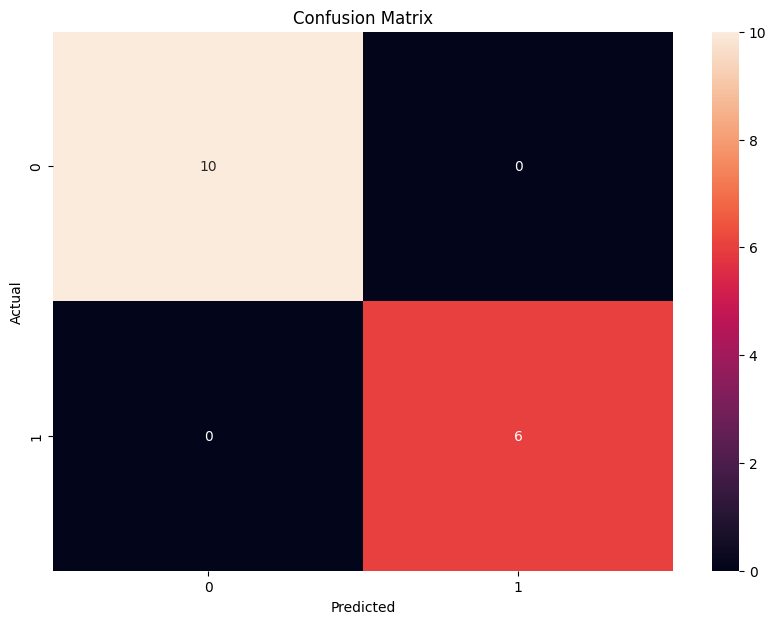

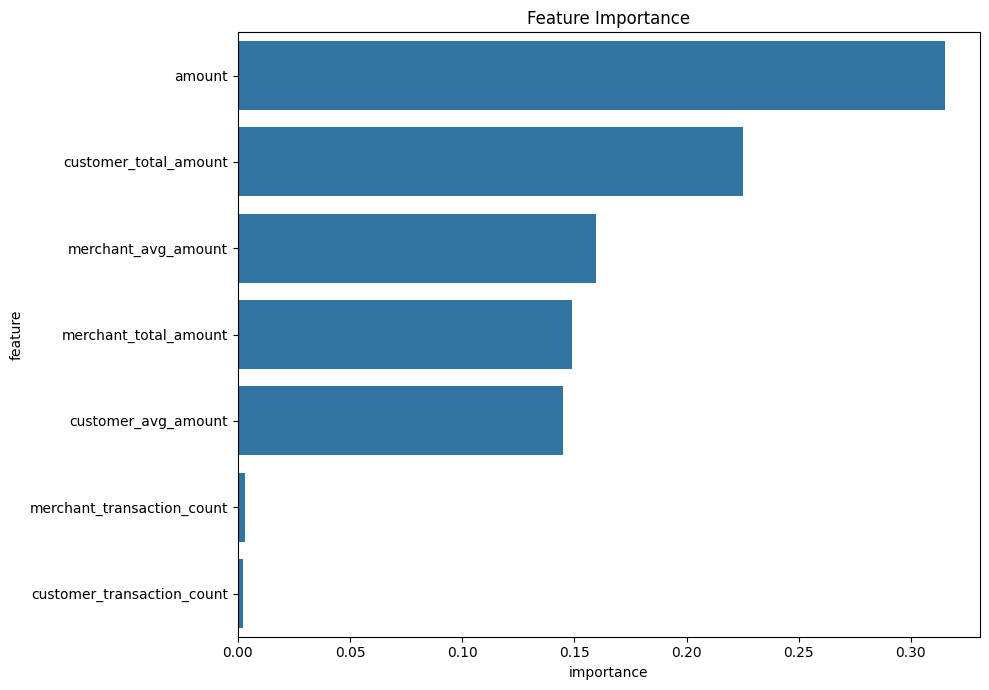

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the prepared data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()

# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# After training your model
joblib.dump(clf, 'random_forest_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

# Make predictions
y_pred = clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')

# Step 7
## Implement Real-time Fraud Detection - This cell provides a function to predict the fraud probability for new transactions.


In [12]:
from neo4j import GraphDatabase
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

uri = "bolt://localhost:7687"
username = "neo4j"
password = "Dairymilk@123"  # Replace with your actual password

driver = GraphDatabase.driver(uri, auth=(username, password))

# Load the trained model and scaler
clf = joblib.load('random_forest_model.joblib')
scaler = joblib.load('scaler.joblib')

def get_transaction_features(tx, customer_id, merchant_id, amount):
    result = tx.run("""
    MATCH (c:Customer {id: $customer_id})
    MATCH (m:Merchant {id: $merchant_id})
    RETURN c.transaction_count AS customer_transaction_count,
           c.total_amount AS customer_total_amount,
           c.avg_transaction_amount AS customer_avg_amount,
           m.transaction_count AS merchant_transaction_count,
           m.total_amount AS merchant_total_amount,
           m.avg_transaction_amount AS merchant_avg_amount
    """, customer_id=customer_id, merchant_id=merchant_id)
    
    record = result.single()
    features = [amount] + list(record.values())
    return features

def predict_fraud(customer_id, merchant_id, amount):
    with driver.session() as session:
        features = session.execute_read(get_transaction_features, customer_id, merchant_id, amount)
    
    features_scaled = scaler.transform([features])
    fraud_probability = clf.predict_proba(features_scaled)[0][1]
    return fraud_probability

# Example usage
print(predict_fraud('C001', 'M001', 10000.00))

driver.close()

0.38


c:\Users\harsh\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\harsh\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
